[[1.15850149e-03 9.85382940e-06 2.23700627e-05 4.44934309e-01
  8.53625708e-04 8.37864168e-03 6.64048246e-04 3.16707474e-06
  4.08711048e-06 5.26960790e-01 2.00156956e-05 5.54376049e-04
  0.00000000e+00 3.26244981e-06 0.00000000e+00 1.30372791e-05
  0.00000000e+00 7.90942833e-03 5.49072183e-06 0.00000000e+00
  4.42464184e-03 4.06516297e-03 0.00000000e+00 5.91562821e-06
  1.37987888e-06 3.62240530e-06 4.36258142e-06]
 [1.88899413e-03 4.97152869e-05 3.85859166e-05 2.92179555e-01
  2.82065501e-03 4.56493907e-03 4.58526716e-04 2.26174288e-05
  1.18399121e-05 6.76736772e-01 7.23569829e-05 2.40975554e-04
  0.00000000e+00 3.04507248e-05 0.00000000e+00 7.75552598e-06
  8.02983436e-07 1.01429066e-02 3.30938565e-05 4.69456063e-06
  7.05597829e-03 3.56586045e-03 0.00000000e+00 3.67789580e-05
  1.99561600e-05 7.74266573e-06 8.44005262e-06]
 [9.75785137e-04 1.76250887e-05 2.04857788e-03 1.57821923e-01
  1.47295371e-03 4.98253806e-03 1.17583164e-04 5.14480143e-06
  1.09831481e-05 8.09577048e-01 6.64

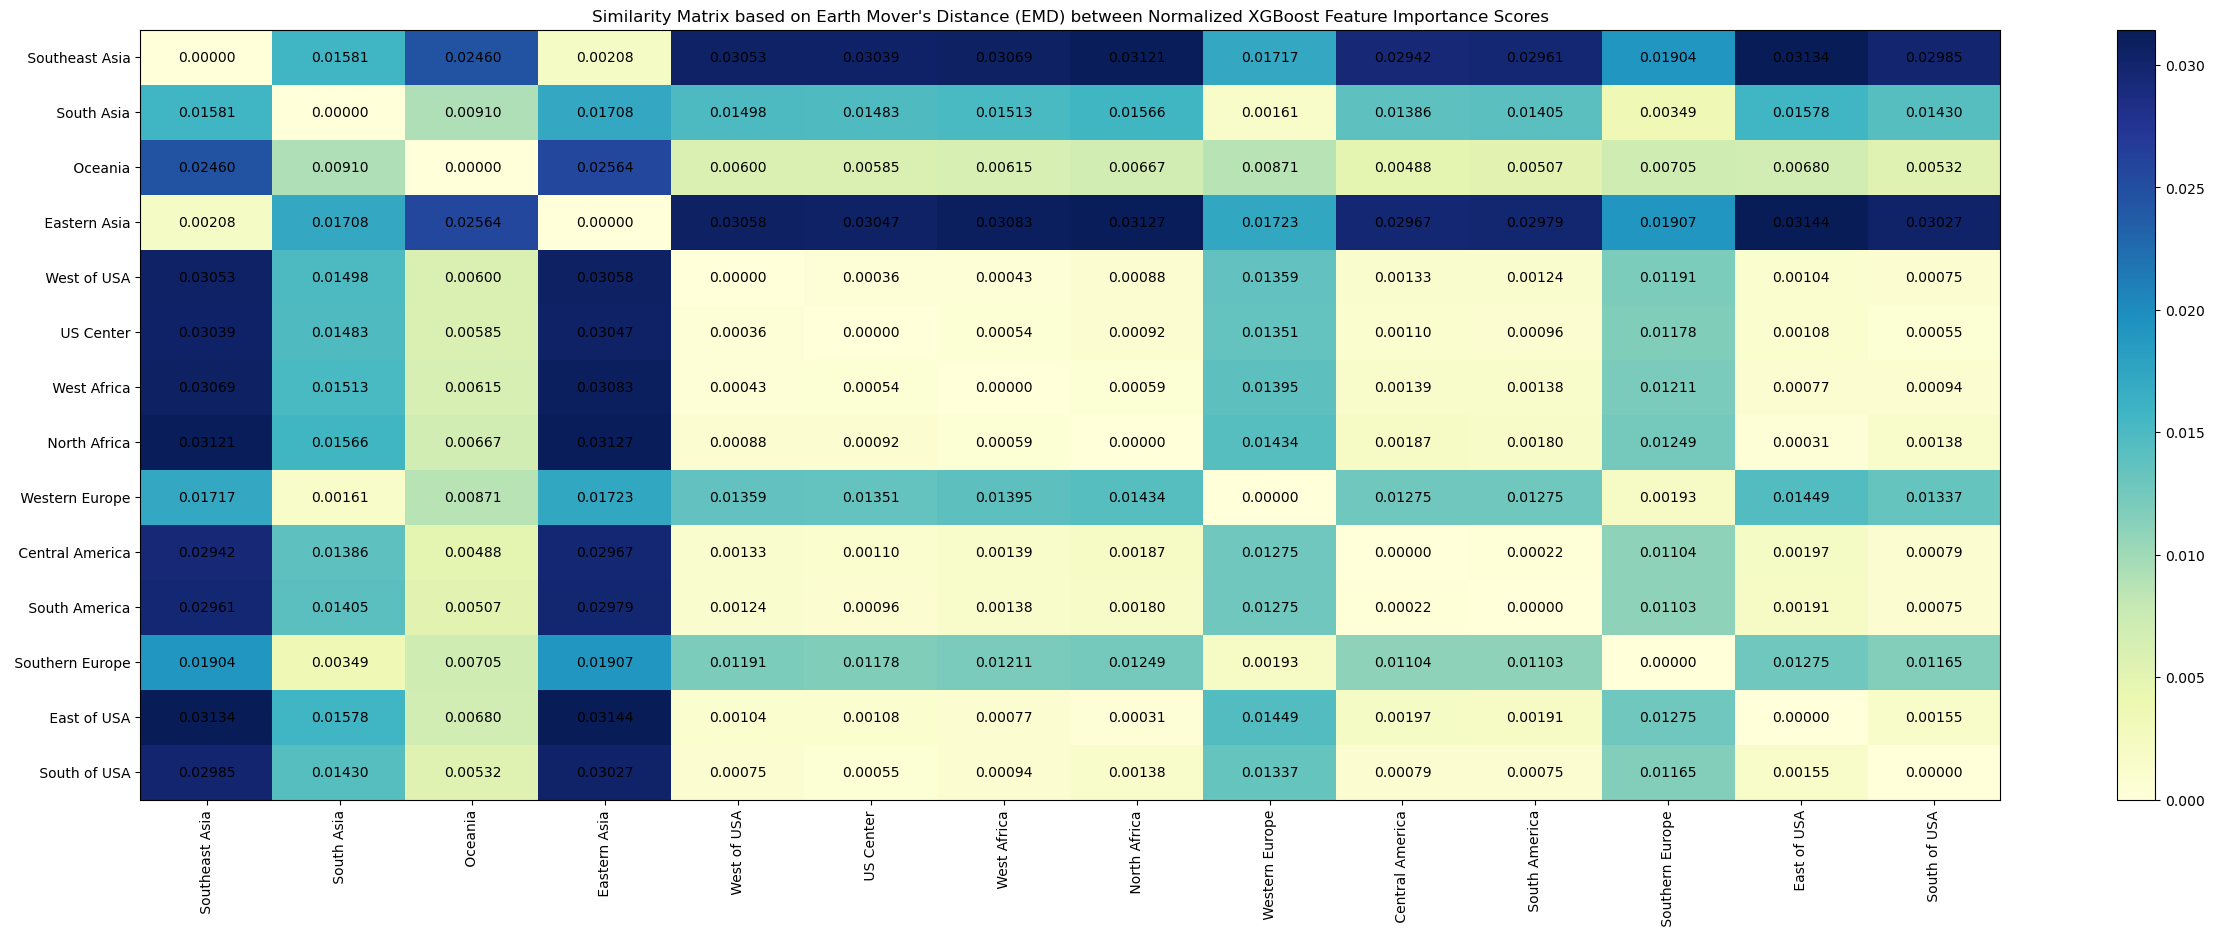

In [62]:
import pandas as pd
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import h5py
import xgboost as xgb
from scipy.stats import wasserstein_distance

region_map = {
    0: "Southeast Asia",
    1: "South Asia",
    2: "Oceania",
    3: "Eastern Asia",
    4: "West Asia",
    5: "West of USA",
    6: "US Center",
    7: "West Africa",
    8: "Central Africa",
    9: "North Africa",
    10: "Western Europe",
    11: "Northern Europe",
    12: "Central America",
    13: "Caribbean",
    14: "South America",
    15: "East Africa",
    16: "Southern Europe",
    17: "East of USA",
    18: "Canada",
    19: "Southern Africa",
    20: "Central Asia",
    21: "Eastern Europe",
    22: "South of USA",
}

# sheet_names = [ str(i) for i in region_map.keys()]
sheet_names = ['0', '1', '2', '3', '5', '6', '7', '9', '10', '12', '14', '16', '17', '22']
dataframes = []

file = h5py.File("market_data.h5", "r")

for sheet_name in sheet_names:

    dataset = file[sheet_name][:]
    dataset = pd.DataFrame(dataset)
    column_names = file[sheet_name].attrs["columns"]
    dataset.columns = column_names
    dataframes.append(dataset)

df = pd.concat(dataframes, ignore_index=True)
df.rename(columns={"Region Index": "Order Region"}, inplace=True)
df["Order Region"] = df["Order Region"].map(region_map)

def calculate_emd(distribution1, distribution2):
    return wasserstein_distance(distribution1, distribution2)

feature_importance_scores = []
df_cluster = df.copy()

for region in df_cluster['Order Region'].unique():
    # Create subset DataFrame for the current Order Region
    subset_df = df_cluster[df_cluster['Order Region'] == region].drop(columns=['Order Region'])

    y = subset_df['Sales'].values

    X = subset_df.drop(columns=['Sales']).values

    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X, y)

    feature_importance_scores.append(model.feature_importances_)

feature_importance_scores = np.array(feature_importance_scores)
print(feature_importance_scores)

num_regions = len(feature_importance_scores)

similarity_matrix_xgboost = np.zeros((num_regions, num_regions))

reverse_mapping = {v: k for k, v in region_map.items()}

region_names = []

for i, region in enumerate(df_cluster['Order Region'].unique()):
    region_names.append(region_map.get(region, f' {region}'))

# Function to normalize feature importance scores
def normalize_feature_importance(feature_importance_scores):
    max_scores = np.max(feature_importance_scores, axis=1)
    normalized_scores = feature_importance_scores / max_scores[:, np.newaxis]
    return normalized_scores

# Normalize feature importance scores
normalized_feature_importance = normalize_feature_importance(feature_importance_scores)
print(normalized_feature_importance.shape)

# Calculate similarity matrix using Earth Mover's Distance
for i in range(num_regions):
    for j in range(i + 1, num_regions):
        emd_value = calculate_emd(normalized_feature_importance[i], normalized_feature_importance[j])
        similarity_matrix_xgboost[i, j] = emd_value
        similarity_matrix_xgboost[j, i] = emd_value

plt.figure(figsize=(30, 10))
plt.imshow(similarity_matrix_xgboost, cmap="YlGnBu", interpolation='nearest', aspect='auto')

for i in range(len(region_names)):
    for j in range(len(region_names)):
        plt.text(j, i, f'{similarity_matrix_xgboost[i, j]:.5f}', ha='center', va='center', color='black')

plt.colorbar()
plt.title('Similarity Matrix based on Earth Mover\'s Distance (EMD) between Normalized XGBoost Feature Importance Scores')
plt.xticks(np.arange(len(region_names)), region_names, rotation=90)
plt.yticks(np.arange(len(region_names)), region_names)
plt.show()


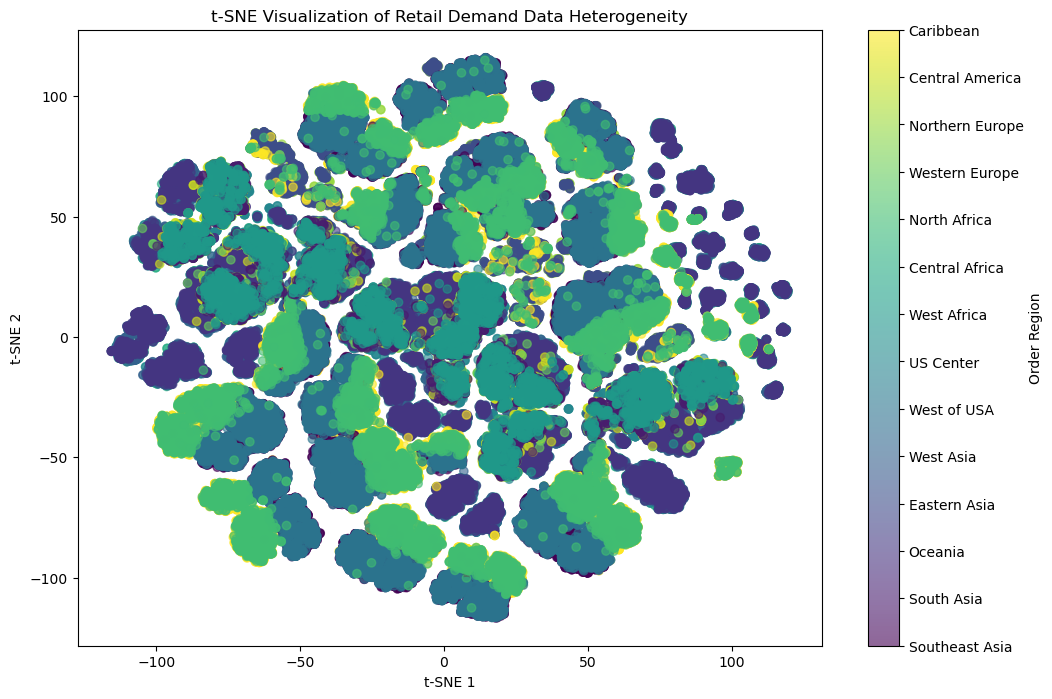

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import h5py
import xgboost as xgb

# Your existing code here...

# Data preprocessing
# Dropping 'Order Region' and 'Sales', and encoding categorical features if needed
X = df_cluster.drop(columns=['Order Region', 'Sales'])
y = df_cluster['Sales']

# Normalize the feature set
X_scaled = StandardScaler().fit_transform(X)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_scaled)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(data=X_embedded, columns=['t-SNE 1', 't-SNE 2'])
tsne_df['Order Region'] = df_cluster['Order Region']

# Plotting
plt.figure(figsize=(12, 8))
scatter = plt.scatter(tsne_df['t-SNE 1'], tsne_df['t-SNE 2'], 
                      c=tsne_df['Order Region'].astype('category').cat.codes,  # Color by region
                      cmap='viridis', alpha=0.6)
plt.title('t-SNE Visualization of Retail Demand Data Heterogeneity')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(scatter, ticks=range(len(region_map)), label='Order Region', 
             format=plt.FuncFormatter(lambda x, _: region_map[int(x)]))
plt.show()


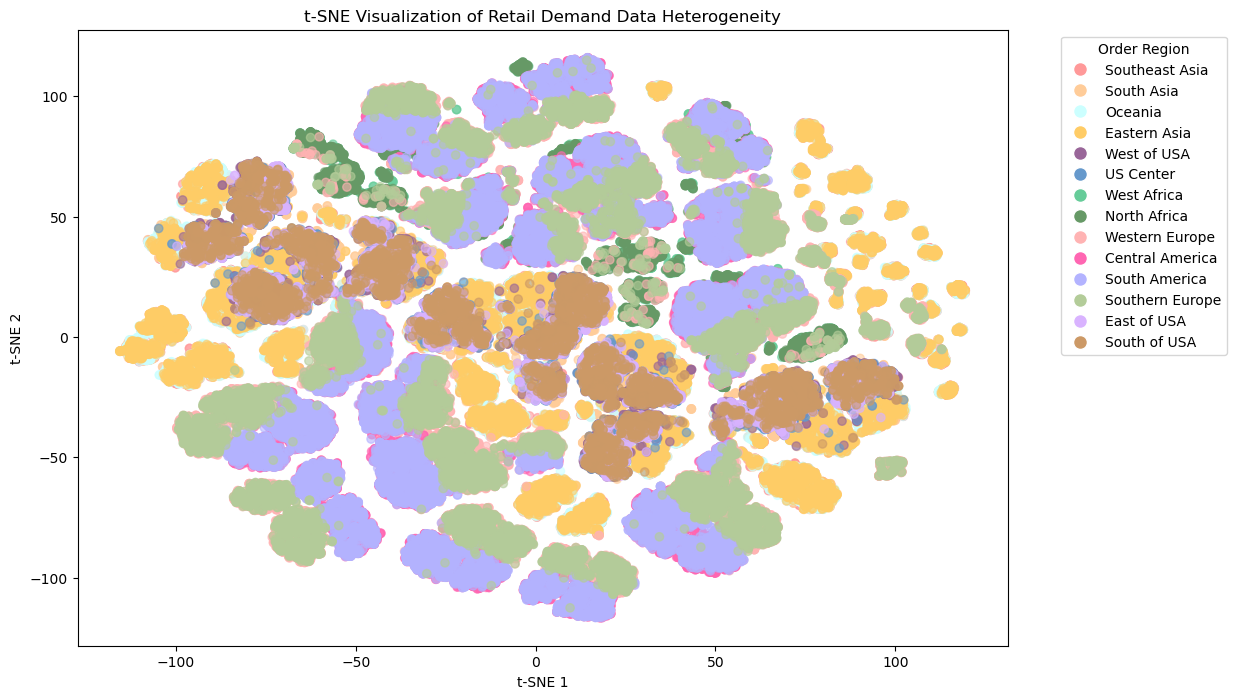

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import h5py
import xgboost as xgb

# Your existing code here...

# Data preprocessing
# Dropping 'Order Region' and 'Sales', and encoding categorical features if needed
X = df_cluster.drop(columns=['Order Region', 'Sales'])
y = df_cluster['Sales']

# Normalize the feature set
X_scaled = StandardScaler().fit_transform(X)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_scaled)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(data=X_embedded, columns=['t-SNE 1', 't-SNE 2'])
tsne_df['Order Region'] = df_cluster['Order Region']

# Define a gradient color map for regions
region_colors = {
    "Southeast Asia": '#FF9999',  # Light Red
    "South Asia": '#FFCC99',       # Light Yellow
    "Oceania": '#CCFFFF',          # Light Cyan
    "Eastern Asia": '#FFCC66',     # Orange
    # "West Asia": '#CC9966',        # Brown
    "West of USA": '#996699',      # Light Purple
    "US Center": '#6699CC',        # Light Blue
    "West Africa": '#66CC99',      # Light Green
    # "Central Africa": '#99CCFF',   # Light Cyan
    "North Africa": '#669966',     # Dark Green
    "Western Europe": '#FFB3B3',   # Soft Pink
    # "Northern Europe": '#D9B3FF',   # Light Lavender
    "Central America": '#FF66B2',  # Soft Pink
    # "Caribbean": '#CC99FF',        # Light Purple
    "South America": '#B3B3FF',    # Soft Blue
    # "East Africa": '#FFCCFF',      # Soft Lavender
    "Southern Europe": '#B3CC99',   # Soft Yellow
    "East of USA": '#D9B3FF',      # Soft Pink
    # "Canada": '#99FFCC',           # Soft Cyan
    # "Southern Africa": '#B3CC99',  # Soft Green
    # "Central Asia": '#CCFFFF',     # Soft Cyan
    # "Eastern Europe": '#FF99CC',   # Soft Pink
    "South of USA": '#CC9966'      # Soft Red
}

# Assign colors based on the region
tsne_df['Color'] = tsne_df['Order Region'].map(region_colors)

# Plotting
plt.figure(figsize=(12, 8))
scatter = plt.scatter(tsne_df['t-SNE 1'], tsne_df['t-SNE 2'], 
                      c=tsne_df['Color'], alpha=0.6)  # Use 'c' for colors

# Create legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label=region,
                       markerfacecolor=region_colors[region], markersize=10) 
           for region in region_colors.keys()]
plt.legend(handles=handles, title='Order Region', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('t-SNE Visualization of Retail Demand Data Heterogeneity')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

plt.show()


In [113]:
tsne_df['Order Region'].unique()

array(['Southeast Asia', 'South Asia', 'Oceania', 'Eastern Asia',
       'West of USA', 'US Center', 'West Africa', 'North Africa',
       'Western Europe', 'Central America', 'South America',
       'Southern Europe', 'East of USA', 'South of USA'], dtype=object)

# agglomerative clustering

In [64]:
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.stats import wasserstein_distance
from sklearn.cluster import KMeans

# Normalize feature importance scores
normalized_feature_importance = normalize_feature_importance(feature_importance_scores)

# Calculate pairwise EMD distances
emd_distances = pairwise_distances(normalized_feature_importance, metric=calculate_emd)

# Calculate linkage matrix using EMD distances
linkage_matrix = linkage(emd_distances, method='average')  # You can adjust the method as desired

# Perform agglomerative clustering
num_clusters = 4  # Set the number of clusters as desired
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Print cluster labels for each region
for region, label in zip(region_names, cluster_labels):
    print(f"Region: {region}, Cluster: {label}")

Region:  Southeast Asia, Cluster: 1
Region:  South Asia, Cluster: 2
Region:  Oceania, Cluster: 4
Region:  Eastern Asia, Cluster: 1
Region:  West of USA, Cluster: 3
Region:  US Center, Cluster: 3
Region:  West Africa, Cluster: 3
Region:  North Africa, Cluster: 3
Region:  Western Europe, Cluster: 2
Region:  Central America, Cluster: 3
Region:  South America, Cluster: 3
Region:  Southern Europe, Cluster: 2
Region:  East of USA, Cluster: 3
Region:  South of USA, Cluster: 3


/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_53987/1171894491.py:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(emd_distances, method='average')  # You can adjust the method as desired


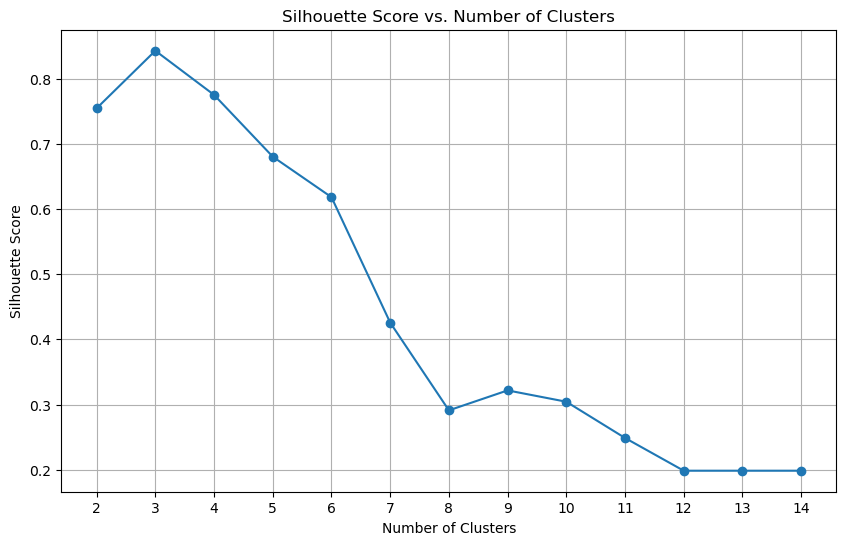

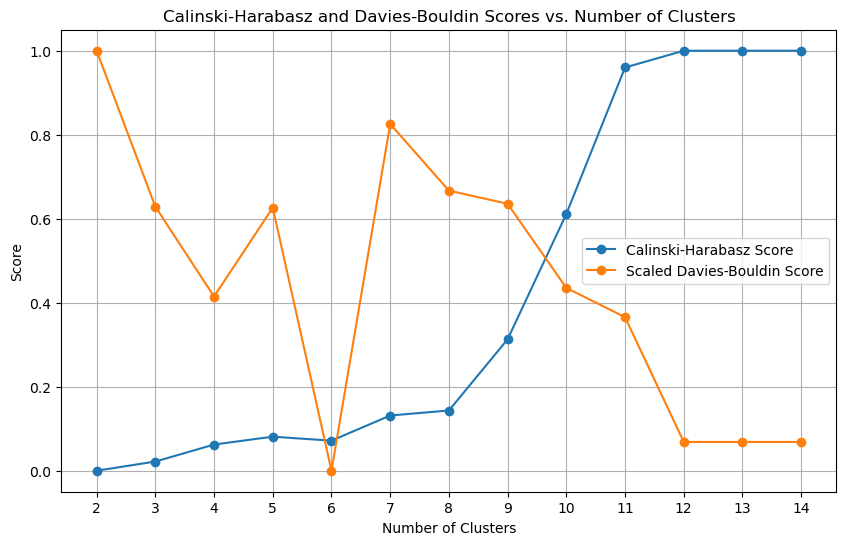

In [65]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Initialize lists to store silhouette scores and other metrics
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

# Range of number of clusters to evaluate
num_clusters_range = range(2, 15)

for num_clusters in num_clusters_range:
    # Perform agglomerative clustering
    cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
    
    # Calculate silhouette score
    silhouette = silhouette_score(emd_distances, cluster_labels)
    silhouette_scores.append(silhouette)
    
    # Calculate Calinski-Harabasz score
    ch_score = calinski_harabasz_score(emd_distances, cluster_labels)
    calinski_harabasz_scores.append(ch_score)
    
    # Calculate Davies-Bouldin score
    db_score = davies_bouldin_score(emd_distances, cluster_labels)
    davies_bouldin_scores.append(db_score)

# Plotting silhouette score
plt.figure(figsize=(10, 6))
plt.plot(num_clusters_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(num_clusters_range)
plt.grid(True)
plt.show()

# Scale Davies-Bouldin scores
scaler = MinMaxScaler()
davies_bouldin_scores_scaled = scaler.fit_transform(np.array(davies_bouldin_scores).reshape(-1, 1)).flatten()
calinski_harabasz_scores = scaler.fit_transform(np.array(calinski_harabasz_scores).reshape(-1, 1)).flatten()

# Plotting both evaluation metrics
plt.figure(figsize=(10, 6))
plt.plot(num_clusters_range, calinski_harabasz_scores, marker='o', label='Calinski-Harabasz Score')
plt.plot(num_clusters_range, davies_bouldin_scores_scaled, marker='o', label='Scaled Davies-Bouldin Score')
plt.title('Calinski-Harabasz and Davies-Bouldin Scores vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.xticks(num_clusters_range)
plt.legend()
plt.grid(True)
plt.show()


# you may prioritize metrics that measure the coherence and separability of the clusters, such as silhouette score, Calinski-Harabasz index, or Davies-Bouldin index.
Use the Silhouette Score when you want to evaluate the overall quality and separation of clusters, especially if you have well-separated clusters.
Use the Davies-Bouldin Index when you want to minimize the average similarity between clusters, especially if you have non-convex or irregularly shaped clusters.

#
Silhouette Score: Silhouette score measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). It ranges from -1 to 1, where a high value indicates that the object is well-matched to its own cluster and poorly matched to neighboring clusters. Silhouette score is useful when you want to evaluate the quality and separation of individual clusters. It's generally preferred when the clusters are well-separated and have a roughly equal number of samples.



Davies-Bouldin Index: The Davies-Bouldin index measures the average similarity between each cluster and its most similar cluster, where similarity is defined based on the ratio of within-cluster scatter to between-cluster separation. A lower Davies-Bouldin index indicates better clustering, with values closer to zero indicating better separation. This index is useful when you want to minimize the average similarity between clusters.

# Differencial Privacy

In [99]:
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics.pairwise import pairwise_distances
from scipy.stats import wasserstein_distance
from sklearn.cluster import KMeans

# Function to add Laplace noise to each subarray
def add_laplace_noise_to_subarrays(array, sensitivity, epsilon):
    noisy_array = np.zeros_like(array)
    for i, subarray in enumerate(array):
        scale = sensitivity / epsilon
        noise = np.random.laplace(loc=0.0, scale=scale, size=subarray.shape)
        noisy_array[i] = subarray + noise
    return noisy_array

# Function to calculate Earth Mover's Distance using Wasserstein distance
def calculate_emd(distribution1, distribution2):
    return wasserstein_distance(distribution1, distribution2)

# Define sensitivity and epsilon as before
sensitivity = 0.001
epsilon_feature_importance = 0.5

# Add Laplace noise to each subarray
noisy_subarrays = [add_laplace_noise_to_subarrays(subarray, sensitivity, epsilon_feature_importance) 
                   for subarray in normalized_feature_importance]

# Calculate pairwise EMD distances with noisy feature importance scores
emd_distances_noisy = pairwise_distances(noisy_subarrays, metric=calculate_emd)

# Calculate linkage matrix using noisy EMD distances
linkage_matrix = linkage(emd_distances_noisy, method='average')  # You can adjust the method as desired

# Perform agglomerative clustering
num_clusters = 4  # Set the number of clusters as desired
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Print cluster labels for each region
for region, label in zip(region_names, cluster_labels):
    print(f"Region: {region}, Cluster: {label}")


Region:  Southeast Asia, Cluster: 1
Region:  South Asia, Cluster: 2
Region:  Oceania, Cluster: 4
Region:  Eastern Asia, Cluster: 1
Region:  West of USA, Cluster: 3
Region:  US Center, Cluster: 3
Region:  West Africa, Cluster: 3
Region:  North Africa, Cluster: 3
Region:  Western Europe, Cluster: 2
Region:  Central America, Cluster: 3
Region:  South America, Cluster: 3
Region:  Southern Europe, Cluster: 2
Region:  East of USA, Cluster: 3
Region:  South of USA, Cluster: 3


/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_53987/2188842364.py:32: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(emd_distances_noisy, method='average')  # You can adjust the method as desired


# DP

[[1.15850149e-03 9.85382940e-06 2.23700627e-05 4.44934309e-01
  8.53625708e-04 8.37864168e-03 6.64048246e-04 3.16707474e-06
  4.08711048e-06 5.26960790e-01 2.00156956e-05 5.54376049e-04
  0.00000000e+00 3.26244981e-06 0.00000000e+00 1.30372791e-05
  0.00000000e+00 7.90942833e-03 5.49072183e-06 0.00000000e+00
  4.42464184e-03 4.06516297e-03 0.00000000e+00 5.91562821e-06
  1.37987888e-06 3.62240530e-06 4.36258142e-06]
 [1.88899413e-03 4.97152869e-05 3.85859166e-05 2.92179555e-01
  2.82065501e-03 4.56493907e-03 4.58526716e-04 2.26174288e-05
  1.18399121e-05 6.76736772e-01 7.23569829e-05 2.40975554e-04
  0.00000000e+00 3.04507248e-05 0.00000000e+00 7.75552598e-06
  8.02983436e-07 1.01429066e-02 3.30938565e-05 4.69456063e-06
  7.05597829e-03 3.56586045e-03 0.00000000e+00 3.67789580e-05
  1.99561600e-05 7.74266573e-06 8.44005262e-06]
 [9.75785137e-04 1.76250887e-05 2.04857788e-03 1.57821923e-01
  1.47295371e-03 4.98253806e-03 1.17583164e-04 5.14480143e-06
  1.09831481e-05 8.09577048e-01 6.64

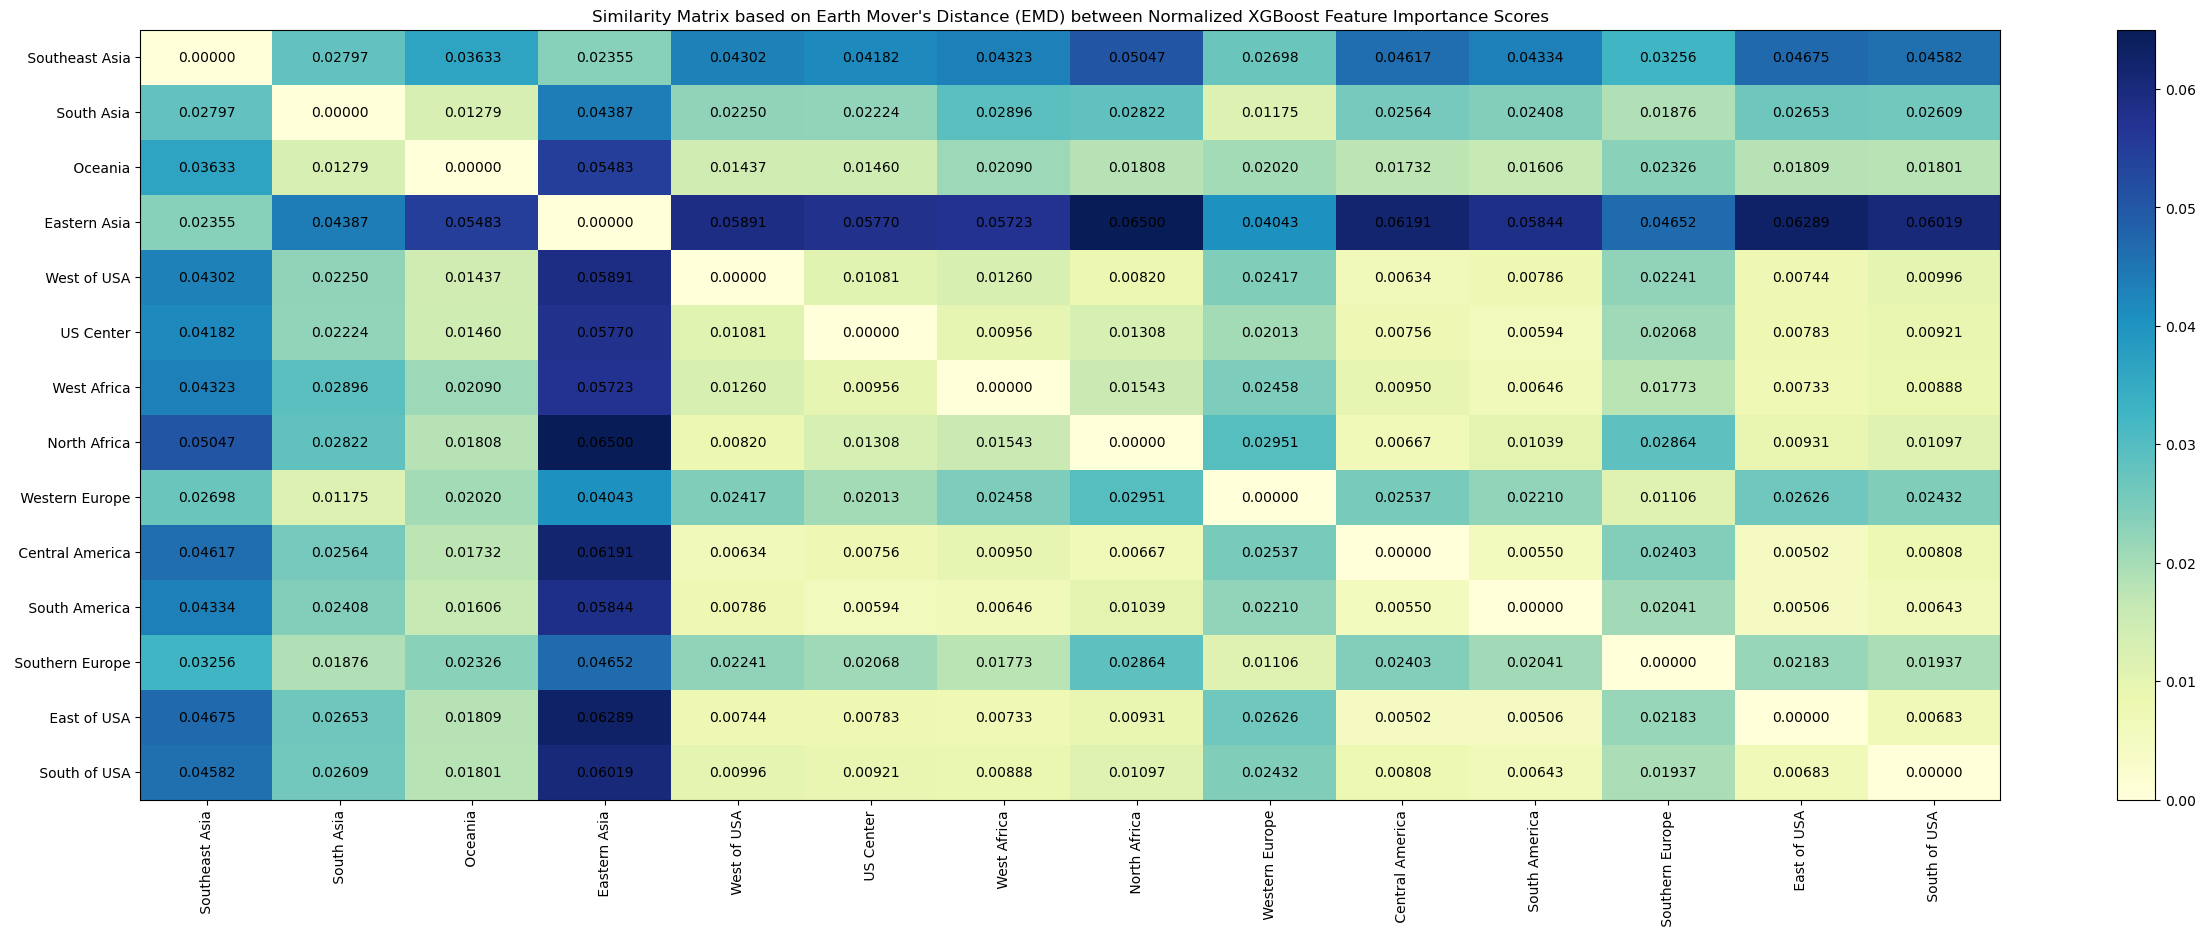

In [3]:
import pandas as pd
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import h5py
import xgboost as xgb
from scipy.stats import wasserstein_distance

region_map = {
    0: "Southeast Asia",
    1: "South Asia",
    2: "Oceania",
    3: "Eastern Asia",
    4: "West Asia",
    5: "West of USA",
    6: "US Center",
    7: "West Africa",
    8: "Central Africa",
    9: "North Africa",
    10: "Western Europe",
    11: "Northern Europe",
    12: "Central America",
    13: "Caribbean",
    14: "South America",
    15: "East Africa",
    16: "Southern Europe",
    17: "East of USA",
    18: "Canada",
    19: "Southern Africa",
    20: "Central Asia",
    21: "Eastern Europe",
    22: "South of USA",
}

# sheet_names = [ str(i) for i in region_map.keys()]
sheet_names = ['0', '1', '2', '3', '5', '6', '7', '9', '10', '12', '14', '16', '17', '22']
dataframes = []

file = h5py.File("market_data.h5", "r")

for sheet_name in sheet_names:

    dataset = file[sheet_name][:]
    dataset = pd.DataFrame(dataset)
    column_names = file[sheet_name].attrs["columns"]
    dataset.columns = column_names
    dataframes.append(dataset)

df = pd.concat(dataframes, ignore_index=True)
df.rename(columns={"Region Index": "Order Region"}, inplace=True)
df["Order Region"] = df["Order Region"].map(region_map)

def calculate_emd(distribution1, distribution2):
    return wasserstein_distance(distribution1, distribution2)

feature_importance_scores = []
df_cluster = df.copy()

for region in df_cluster['Order Region'].unique():
    # Create subset DataFrame for the current Order Region
    subset_df = df_cluster[df_cluster['Order Region'] == region].drop(columns=['Order Region'])

    y = subset_df['Sales'].values

    X = subset_df.drop(columns=['Sales']).values

    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X, y)

    feature_importance_scores.append(model.feature_importances_)

feature_importance_scores = np.array(feature_importance_scores)
print(feature_importance_scores)

num_regions = len(feature_importance_scores)

similarity_matrix_xgboost = np.zeros((num_regions, num_regions))

reverse_mapping = {v: k for k, v in region_map.items()}

region_names = []

for i, region in enumerate(df_cluster['Order Region'].unique()):
    region_names.append(region_map.get(region, f' {region}'))




import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics.pairwise import pairwise_distances
from scipy.stats import wasserstein_distance
from sklearn.cluster import KMeans

# Function to add Laplace noise to each subarray
def add_laplace_noise_to_subarrays(array, sensitivity, epsilon):
    noisy_array = np.zeros_like(array)
    for i, subarray in enumerate(array):
        scale = sensitivity / epsilon
        noise = np.random.laplace(loc=0.0, scale=scale, size=subarray.shape)
        noisy_array[i] = subarray + noise
    return noisy_array

# Function to calculate Earth Mover's Distance using Wasserstein distance
def calculate_emd(distribution1, distribution2):
    return wasserstein_distance(distribution1, distribution2)

# Define sensitivity and epsilon as before
sensitivity = 0.01
epsilon = 0.5

best_epsilon = None
best_cluster_labels = None
best_silhouette_score = float('-inf')



print(feature_importance_scores.shape)

noisy_subarrays = [add_laplace_noise_to_subarrays(subarray, sensitivity, epsilon) 
                    for subarray in feature_importance_scores]

def normalize_feature_importance(feature_importance_scores):
    max_scores = np.max(feature_importance_scores, axis=1)
    normalized_scores = feature_importance_scores / max_scores[:, np.newaxis]
    return normalized_scores


noisy_subarrays = normalize_feature_importance(noisy_subarrays)

# Calculate similarity matrix using Earth Mover's Distance
for i in range(num_regions):
    for j in range(i + 1, num_regions):
        emd_value = calculate_emd(noisy_subarrays[i], noisy_subarrays[j])
        similarity_matrix_xgboost[i, j] = emd_value
        similarity_matrix_xgboost[j, i] = emd_value

plt.figure(figsize=(30, 10))
plt.imshow(similarity_matrix_xgboost, cmap="YlGnBu", interpolation='nearest', aspect='auto')

for i in range(len(region_names)):
    for j in range(len(region_names)):
        plt.text(j, i, f'{similarity_matrix_xgboost[i, j]:.5f}', ha='center', va='center', color='black')

plt.colorbar()
plt.title('Similarity Matrix based on Earth Mover\'s Distance (EMD) between Normalized XGBoost Feature Importance Scores')
plt.xticks(np.arange(len(region_names)), region_names, rotation=90)
plt.yticks(np.arange(len(region_names)), region_names)
plt.show()


In [5]:
def calculate_sensitivity(subset_df):
    y = subset_df['Sales'].values
    X = subset_df.drop(columns=['Sales']).values
    
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X, y)
    feature_importance_full = model.feature_importances_
    
    # Calculate sensitivity for each record removal
    sensitivities = []
    for i in range(len(subset_df)):
        # Remove a single record
        X_reduced = np.delete(X, i, axis=0)
        y_reduced = np.delete(y, i, axis=0)
        model.fit(X_reduced, y_reduced)
        feature_importance_reduced = model.feature_importances_
        
        # Calculate the difference (L1 norm)
        sensitivity = np.sum(np.abs(feature_importance_full - feature_importance_reduced))
        sensitivities.append(sensitivity)
    
    return max(sensitivities)
subset_df = df_cluster[df_cluster['Order Region'] == region].drop(columns=['Order Region'])
# Example for a region
region_sensitivity = calculate_sensitivity(subset_df)
print("Sensitivity for the region:", region_sensitivity)


Sensitivity for the region: 0.042577013


In [6]:
import numpy as np
import xgboost as xgb

# Function to calculate sensitivity for each region
def calculate_sensitivity_for_region(region_df):
    sensitivities = []
    subset_df = region_df.copy()
    
    # Target variable
    y = subset_df['Sales'].values
    # Features
    X = subset_df.drop(columns=['Sales']).values
    
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X, y)
    
    feature_importance_full = model.feature_importances_
    
    # Calculate sensitivity by removing each record and re-training the model
    for i in range(len(subset_df)):
        subset_df_removed = subset_df.drop(subset_df.index[i])
        X_removed = subset_df_removed.drop(columns=['Sales']).values
        y_removed = subset_df_removed['Sales'].values
        
        model.fit(X_removed, y_removed)
        feature_importance_removed = model.feature_importances_
        
        # Sensitivity is the maximum change in feature importance
        sensitivities.append(np.max(np.abs(feature_importance_full - feature_importance_removed)))
    
    # Return the maximum sensitivity for the region
    return max(sensitivities)

# Calculate sensitivity for each client (region) and store the sensitivities
region_sensitivities = {}

for region in df_cluster['Order Region'].unique():
    # Create a subset DataFrame for the current region (client)
    subset_df = df_cluster[df_cluster['Order Region'] == region].drop(columns=['Order Region'])
    
    # Calculate sensitivity for this region
    sensitivity_for_region = calculate_sensitivity_for_region(subset_df)
    
    # Store sensitivity for this region
    region_sensitivities[region] = sensitivity_for_region
    print(f"Sensitivity for region {region}: {sensitivity_for_region}")

# Now you can use these sensitivities to add Laplace noise individually per client


Sensitivity for region Southeast Asia: 0.0650767982006073
Sensitivity for region South Asia: 0.05257868766784668
Sensitivity for region Oceania: 0.02684265375137329
Sensitivity for region Eastern Asia: 0.051543861627578735
Sensitivity for region West of USA: 0.01627231389284134
Sensitivity for region US Center: 0.019458532333374023
Sensitivity for region West Africa: 0.013767920434474945
Sensitivity for region North Africa: 0.018364667892456055
Sensitivity for region Western Europe: 0.035552978515625
Sensitivity for region Central America: 0.018495261669158936
Sensitivity for region South America: 0.022706568241119385
Sensitivity for region Southern Europe: 0.06067335605621338
Sensitivity for region East of USA: 0.009347498416900635
Sensitivity for region South of USA: 0.020358383655548096


{'Southeast Asia': 0.0650767982006073, 'South Asia': 0.05257868766784668, 'Oceania': 0.02684265375137329, 'Eastern Asia': 0.051543861627578735, 'West of USA': 0.01627231389284134, 'US Center': 0.019458532333374023, 'West Africa': 0.013767920434474945, 'North Africa': 0.018364667892456055, 'Western Europe': 0.035552978515625, 'Central America': 0.018495261669158936, 'South America': 0.022706568241119385, 'Southern Europe': 0.06067335605621338, 'East of USA': 0.009347498416900635, 'South of USA': 0.020358383655548096}


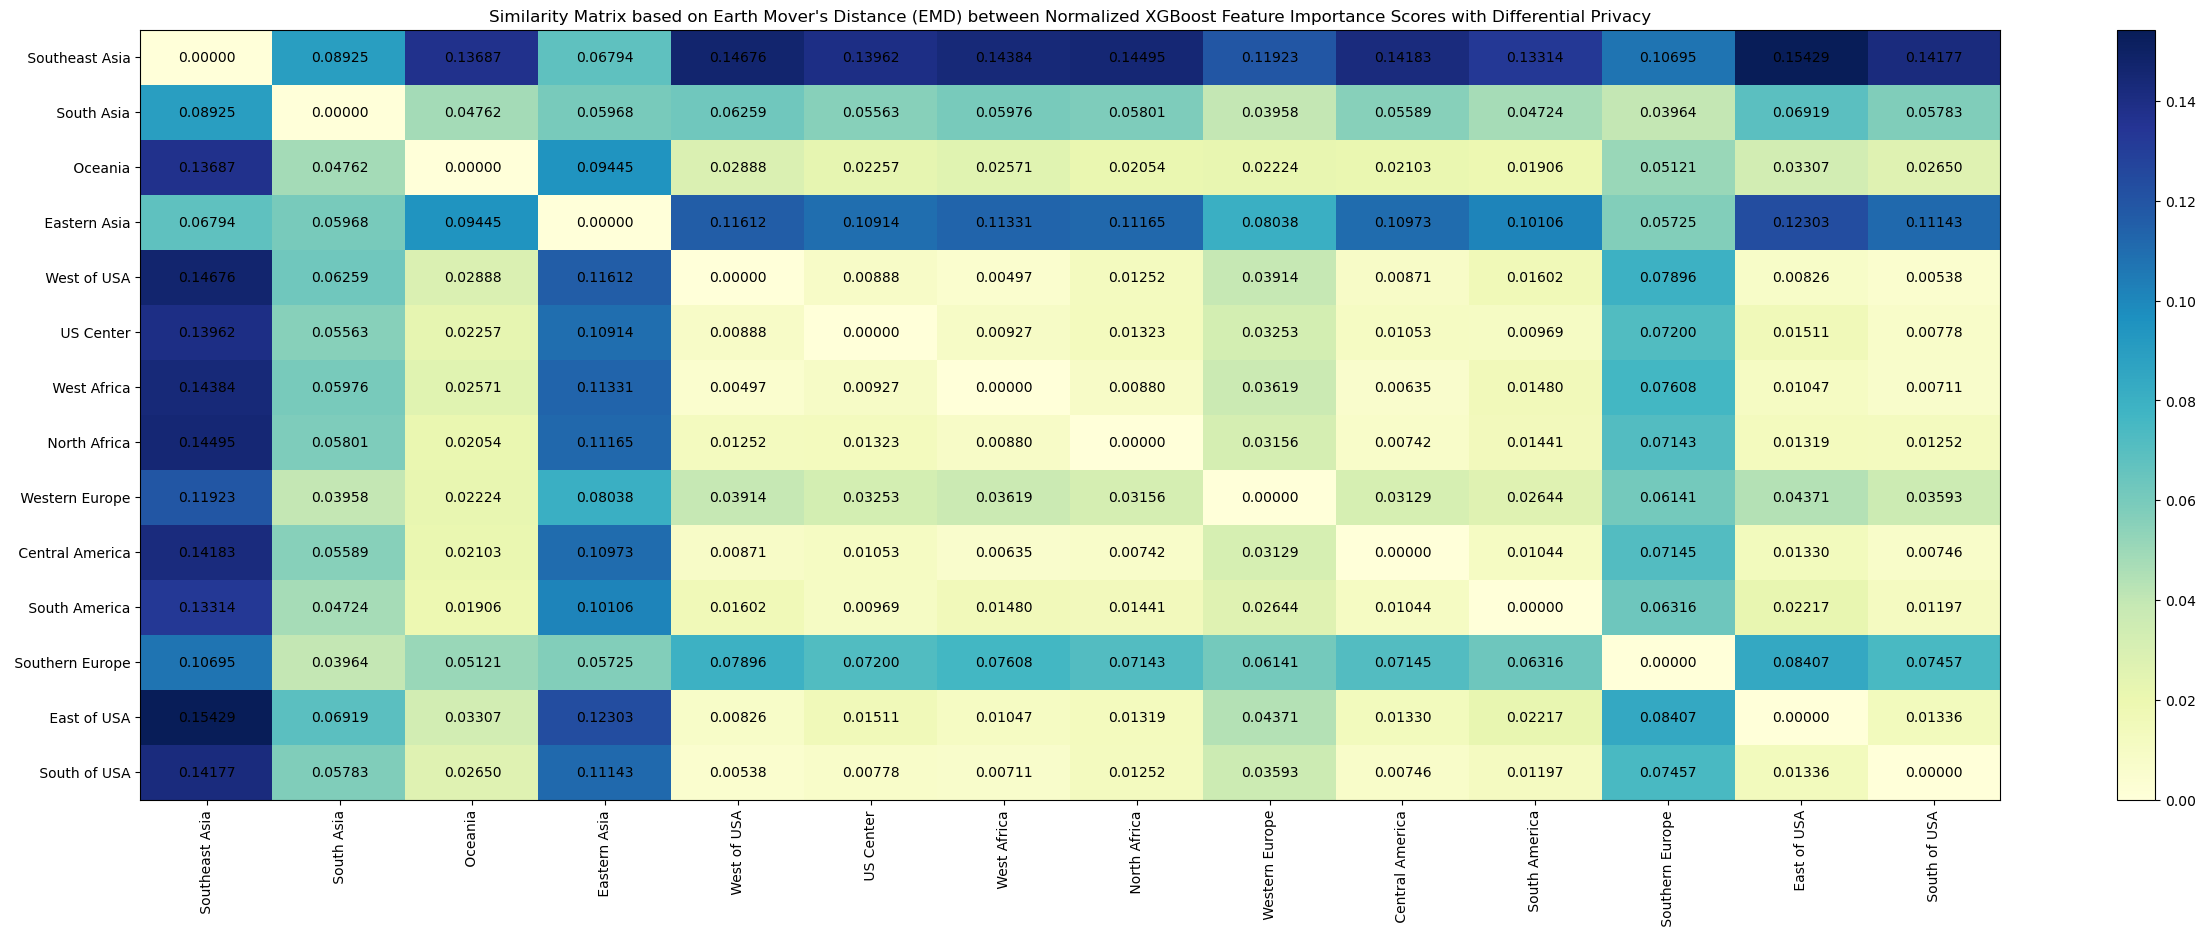

Region:  Southeast Asia, Cluster: 1
Region:  South Asia, Cluster: 3
Region:  Oceania, Cluster: 6
Region:  Eastern Asia, Cluster: 2
Region:  West of USA, Cluster: 5
Region:  US Center, Cluster: 5
Region:  West Africa, Cluster: 5
Region:  North Africa, Cluster: 5
Region:  Western Europe, Cluster: 7
Region:  Central America, Cluster: 5
Region:  South America, Cluster: 5
Region:  Southern Europe, Cluster: 4
Region:  East of USA, Cluster: 5
Region:  South of USA, Cluster: 5


/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_53987/1207440142.py:97: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(similarity_matrix_xgboost, method='average')  # You can adjust the method as desired


In [162]:
# Sensitivity values for each region



region_sensitivity_map = {
    "Southeast Asia": 0.0650767982006073,
    "South Asia": 0.05257868766784668,
    "Oceania": 0.02684265375137329,
    "Eastern Asia": 0.051543861627578735,
    "West of USA": 0.01627231389284134,
    "US Center": 0.019458532333374023,
    "West Africa": 0.013767920434474945,
    "North Africa": 0.018364667892456055,
    "Western Europe": 0.035552978515625,
    "Central America": 0.018495261669158936,
    "South America": 0.022706568241119385,
    "Southern Europe": 0.06067335605621338,
    "East of USA": 0.009347498416900635,
    "South of USA": 0.020358383655548096
}

# # Set all regions to have the same sensitivity value of 0.01
# uniform_sensitivity = 0.01
# region_sensitivity_map = {region: uniform_sensitivity for region in region_sensitivity_map.keys()}

# Print the updated region sensitivity map to confirm changes
print(region_sensitivity_map)

np.random.seed(0)
# Ensure only regions in the data are included
region_sensitivity_map = {region: region_sensitivity_map[region] for region in df_cluster['Order Region'].unique()}

# Function to add Laplace noise with unique sensitivities for each region
# Corrected function to apply Laplace noise with the correct sensitivity
def add_laplace_noise_to_subarrays(array, sensitivity, epsilon):
    noisy_array = np.zeros_like(array)
    for i, subarray in enumerate(array):
        scale = float(sensitivity) / epsilon
        noise = np.random.laplace(loc=0.0, scale=scale, size=subarray.shape)
        
        noisy_array[i] = subarray + noise
    return noisy_array

# Apply noise to feature importance scores for each region
noisy_feature_importance_scores = []
epsilon = 10
# Loop over each region and apply Laplace noise
for i, region in enumerate(df_cluster['Order Region'].unique()):
    sensitivity = region_sensitivity_map[region]  # Get the sensitivity for the region
    noisy_feature_importance = add_laplace_noise_to_subarrays(feature_importance_scores[i], sensitivity, epsilon)
    noisy_feature_importance_scores.append(noisy_feature_importance)

# Convert the list back to a numpy array
noisy_feature_importance_scores = np.array(noisy_feature_importance_scores)


def normalize_feature_importance(feature_importance_scores):
    max_scores = np.max(feature_importance_scores, axis=1)
    normalized_scores = feature_importance_scores / max_scores[:, np.newaxis]
    return normalized_scores

# Normalize noisy feature importance scores
noisy_feature_importance_scores = normalize_feature_importance(noisy_feature_importance_scores)




# Function to calculate Earth Mover's Distance using Wasserstein distance
def calculate_emd(distribution1, distribution2):
    return wasserstein_distance(distribution1, distribution2)


# Calculate similarity matrix using Earth Mover's Distance
for i in range(num_regions):
    for j in range(i + 1, num_regions):
        emd_value = calculate_emd(noisy_feature_importance_scores[i], noisy_feature_importance_scores[j])
        similarity_matrix_xgboost[i, j] = emd_value
        similarity_matrix_xgboost[j, i] = emd_value
        

# Plot the similarity matrix
plt.figure(figsize=(30, 10))
plt.imshow(similarity_matrix_xgboost, cmap="YlGnBu", interpolation='nearest', aspect='auto')

for i in range(len(region_names)):
    for j in range(len(region_names)):
        plt.text(j, i, f'{similarity_matrix_xgboost[i, j]:.5f}', ha='center', va='center', color='black')
        

plt.colorbar()
plt.title('Similarity Matrix based on Earth Mover\'s Distance (EMD) between Normalized XGBoost Feature Importance Scores with Differential Privacy')
plt.xticks(np.arange(len(region_names)), region_names, rotation=90)
plt.yticks(np.arange(len(region_names)), region_names)
plt.show()

# Calculate linkage matrix using noisy EMD distances
linkage_matrix = linkage(similarity_matrix_xgboost, method='average')  # You can adjust the method as desired

# Perform agglomerative clustering
num_clusters = 7  # Set the number of clusters as desired
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Print cluster labels for each region
for region, label in zip(region_names, cluster_labels):
    print(f"Region: {region}, Cluster: {label}")

In [21]:
# import pandas as pd
# from sklearn.metrics import silhouette_score
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.cluster import AgglomerativeClustering
# import h5py
# import xgboost as xgb
# from scipy.stats import wasserstein_distance

# # Your existing region_map and data loading code here...

# # Function to add Laplace noise to each subarray
# def add_laplace_noise_to_subarrays(array, sensitivity, epsilon):
#     noisy_array = np.zeros_like(array)
#     for i, subarray in enumerate(array):
#         scale = sensitivity / epsilon
#         noise = np.random.laplace(loc=0.0, scale=scale, size=subarray.shape)
#         noisy_array[i] = subarray + noise
#     return noisy_array

# # Function to calculate Earth Mover's Distance using Wasserstein distance
# def calculate_emd(distribution1, distribution2):
#     return wasserstein_distance(distribution1, distribution2)

# # Define sensitivity
# sensitivity = 0.01

# # Number of iterations and epsilon values
# num_iterations = 100
# epsilon_values = np.random.uniform(0.1, 1, num_iterations)  # Random epsilon values between 0.1 and 100

# # Prepare to store results
# silhouette_scores = []

# for epsilon in epsilon_values:
#     noisy_subarrays = [add_laplace_noise_to_subarrays(subarray, sensitivity, epsilon) 
#                         for subarray in feature_importance_scores]
    
#     # Normalize noisy feature importance scores
#     noisy_subarrays = normalize_feature_importance(noisy_subarrays)
    
#     # Calculate similarity matrix using EMD
#     similarity_matrix_xgboost = np.zeros((num_regions, num_regions))
    
#     for i in range(num_regions):
#         for j in range(i + 1, num_regions):
#             emd_value = calculate_emd(noisy_subarrays[i], noisy_subarrays[j])
#             similarity_matrix_xgboost[i, j] = emd_value
#             similarity_matrix_xgboost[j, i] = emd_value
    
#     # Clustering using AgglomerativeClustering
#     clustering_model = AgglomerativeClustering(n_clusters=num_regions, affinity='precomputed', linkage='average')
#     cluster_labels = clustering_model.fit_predict(similarity_matrix_xgboost)
    
#     # Calculate silhouette score
#     score = silhouette_score(similarity_matrix_xgboost, cluster_labels, metric='precomputed')
#     silhouette_scores.append(score)

# # Plotting the results
# plt.figure(figsize=(10, 6))
# plt.plot(epsilon_values, silhouette_scores, marker='o', linestyle='-', color='b')
# plt.title('Silhouette Scores vs Epsilon Values')
# plt.xlabel('Epsilon Values')
# plt.ylabel('Silhouette Score')
# plt.grid()
# plt.axhline(y=0.6, color='r', linestyle='--', label='Utility Threshold (0.6)')
# plt.legend()
# plt.show()


In [36]:
region_map = {
    0: "Southeast Asia",
    1: "South Asia",
    2: "Oceania",
    3: "Eastern Asia",
    4: "West Asia",
    5: "West of USA",
    6: "US Center",
    7: "West Africa",
    8: "Central Africa",
    9: "North Africa",
    10: "Western Europe",
    11: "Northern Europe",
    12: "Central America",
    13: "Caribbean",
    14: "South America",
    15: "East Africa",
    16: "Southern Europe",
    17: "East of USA",
    18: "Canada",
    19: "Southern Africa",
    20: "Central Asia",
    21: "Eastern Europe",
    22: "South of  USA",
}

sheet_names = ['0', '1', '2', '3', '5', '6', '7', '9', '10', '12', '14', '16', '17', '22']
region_names = [region_map[int(sheet_name)] for sheet_name in sheet_names]
region_names_tuple = tuple(region_names)

print(region_names_tuple)

('Southeast Asia', 'South Asia', 'Oceania', 'Eastern Asia', 'West of USA', 'US Center', 'West Africa', 'North Africa', 'Western Europe', 'Central America', 'South America', 'Southern Europe', 'East of USA', 'South of  USA')


In [8]:
# from sklearn.metrics.pairwise import pairwise_distances
# from scipy.cluster.hierarchy import linkage, fcluster
# from scipy.stats import wasserstein_distance
# from sklearn.cluster import KMeans


# # Calculate pairwise EMD distances
# emd_distances = pairwise_distances(noisy_subarrays, metric=calculate_emd)

# # Calculate linkage matrix using EMD distances
# linkage_matrix = linkage(emd_distances, method='average')  # You can adjust the method as desired

# # Perform agglomerative clustering
# num_clusters = 7  # Set the number of clusters as desired
# cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# # Print cluster labels for each region
# for region, label in zip(region_names, cluster_labels):
#     print(f"Region: {region}, Cluster: {label}")

In [151]:
# from scipy.cluster.hierarchy import linkage, fcluster

# # Perform agglomerative clustering based on the similarity matrix
# # We use 'complete' linkage for hierarchical clustering
# linkage_matrix = linkage(similarity_matrix_xgboost, method='complete')

# # Set the number of clusters
# num_clusters = 3  # Adjust this to the desired number of clusters
# cluster_labels = fcluster(similarity_matrix_xgboost, num_clusters, criterion='maxclust')

# # Print the cluster labels for each region
# print("Agglomerative Clustering Results:\n")
# for region, label in zip(region_names, cluster_labels):
#     print(f"Region: {region}, Cluster: {label}")

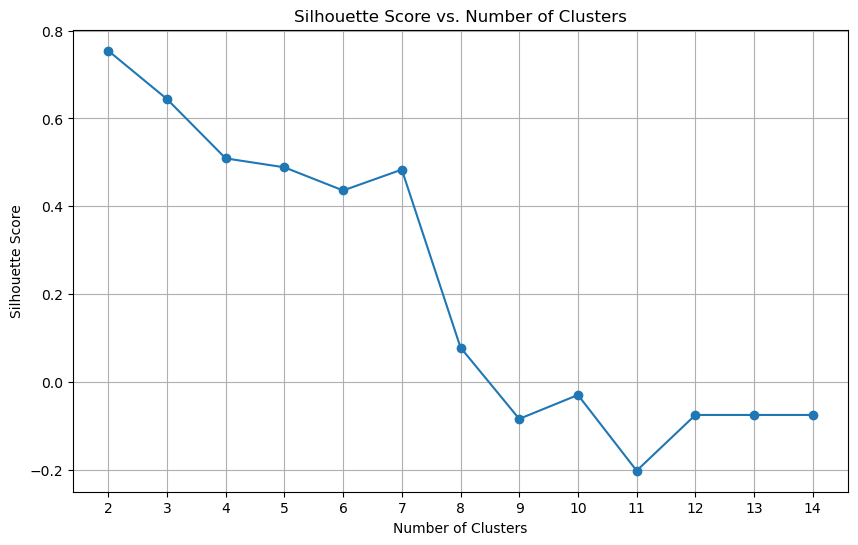

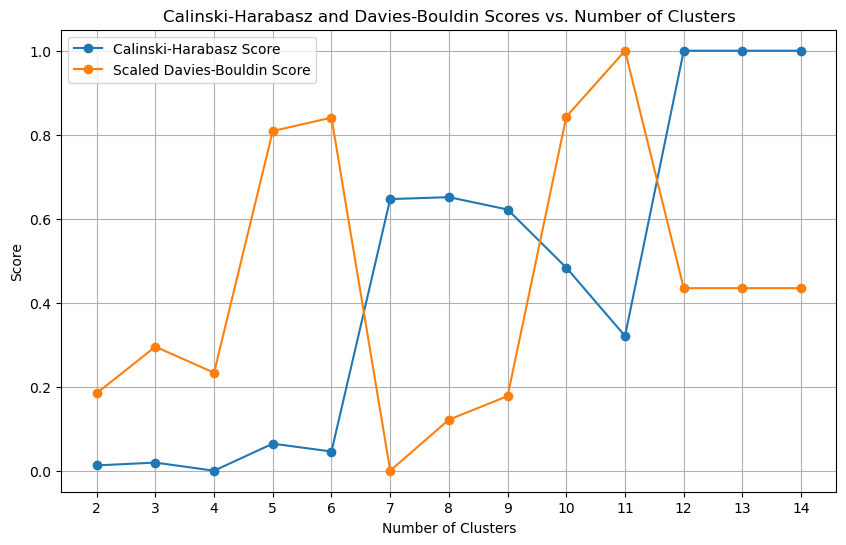

In [161]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Initialize lists to store silhouette scores and other metrics
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

# Range of number of clusters to evaluate
num_clusters_range = range(2, 15)

for num_clusters in num_clusters_range:
    # Perform agglomerative clustering
    cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
    
    # Calculate silhouette score
    silhouette = silhouette_score(emd_distances, cluster_labels)
    silhouette_scores.append(silhouette)
    
    # Calculate Calinski-Harabasz score
    ch_score = calinski_harabasz_score(emd_distances, cluster_labels)
    calinski_harabasz_scores.append(ch_score)
    
    # Calculate Davies-Bouldin score
    db_score = davies_bouldin_score(emd_distances, cluster_labels)
    davies_bouldin_scores.append(db_score)

# Plotting silhouette score
plt.figure(figsize=(10, 6))
plt.plot(num_clusters_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(num_clusters_range)
plt.grid(True)
plt.show()

# Scale Davies-Bouldin scores
scaler = MinMaxScaler()
davies_bouldin_scores_scaled = scaler.fit_transform(np.array(davies_bouldin_scores).reshape(-1, 1)).flatten()
calinski_harabasz_scores = scaler.fit_transform(np.array(calinski_harabasz_scores).reshape(-1, 1)).flatten()

# Plotting both evaluation metrics
plt.figure(figsize=(10, 6))
plt.plot(num_clusters_range, calinski_harabasz_scores, marker='o', label='Calinski-Harabasz Score')
plt.plot(num_clusters_range, davies_bouldin_scores_scaled, marker='o', label='Scaled Davies-Bouldin Score')
plt.title('Calinski-Harabasz and Davies-Bouldin Scores vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.xticks(num_clusters_range)
plt.legend()
plt.grid(True)
plt.show()


In [15]:
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics.pairwise import pairwise_distances
from scipy.stats import wasserstein_distance
from sklearn.cluster import KMeans


# Function to add Laplace noise to each subarray
def add_laplace_noise_to_subarrays(array, sensitivity, epsilon):
    noisy_array = np.zeros_like(array)
    for i, subarray in enumerate(array):
        scale = sensitivity / epsilon
        noise = np.random.laplace(loc=0.0, scale=scale, size=subarray.shape)
        noisy_array[i] = subarray + noise
    return noisy_array

# Function to calculate Earth Mover's Distance using Wasserstein distance
def calculate_emd(distribution1, distribution2):
    return wasserstein_distance(distribution1, distribution2)

# Define sensitivity and epsilon as before
sensitivity = 0.01
epsilon_range = [i / 100 for i in range(1, 100, 1)]

best_epsilon = None
best_cluster_labels = None
best_silhouette_score = float('-inf')

# Iterate over epsilon values
for epsilon in epsilon_range:
    # Add Laplace noise to each subarray
    noisy_subarrays = [add_laplace_noise_to_subarrays(subarray, sensitivity, epsilon) 
                       for subarray in normalized_feature_importance]
    
    # Calculate pairwise EMD distances with noisy feature importance scores
    emd_distances_noisy = pairwise_distances(noisy_subarrays, metric=calculate_emd)

    # Calculate linkage matrix using noisy EMD distances
    linkage_matrix = linkage(emd_distances_noisy, method='average')

    # Perform agglomerative clustering
    num_clusters = 3
    cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

    # Evaluate clustering quality
    from sklearn.metrics import silhouette_score
    silhouette_score_value = silhouette_score(noisy_subarrays, cluster_labels)
    
    # # Print epsilon and clustering quality
    # print(f"Epsilon: {epsilon}, Silhouette Score: {silhouette_score_value}")

    # Update best epsilon and clustering quality if improved
    if silhouette_score_value > best_silhouette_score:
        best_epsilon = epsilon
        best_cluster_labels = cluster_labels
        best_silhouette_score = silhouette_score_value

# Print the best epsilon and corresponding cluster labels
print(f"Best Epsilon: {best_epsilon}, Best Silhouette Score: {best_silhouette_score}")

# Print cluster labels for each region
for region, label in zip(region_names, best_cluster_labels):
    print(f"Region: {region}, Cluster: {label}")


/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_21412/2784329123.py:39: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(emd_distances_noisy, method='average')
/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_21412/2784329123.py:39: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(emd_distances_noisy, method='average')
/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_21412/2784329123.py:39: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(emd_distances_noisy, method='average')
/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_21412/2784329123.py:39: ClusterWarning: scipy.cluster: The symmetric non-nega

Best Epsilon: 0.93, Best Silhouette Score: 0.749900221824646
Region: Southeast Asia, Cluster: 1
Region: South Asia, Cluster: 2
Region: Oceania, Cluster: 3
Region: Eastern Asia, Cluster: 1
Region: West Asia, Cluster: 3
Region: West of USA, Cluster: 3
Region: US Center, Cluster: 3
Region: West Africa, Cluster: 3
Region: Central Africa, Cluster: 3
Region: North Africa, Cluster: 3
Region: Western Europe, Cluster: 2
Region: Northern Europe, Cluster: 2
Region: Central America, Cluster: 3
Region: Caribbean, Cluster: 3
Region: South America, Cluster: 3
Region: East Africa, Cluster: 3
Region: Southern Europe, Cluster: 2
Region: East of USA, Cluster: 3
Region: Canada, Cluster: 3
Region: Southern Africa, Cluster: 3
Region: Central Asia, Cluster: 3
Region: Eastern Europe, Cluster: 3
Region: South of  USA, Cluster: 3


/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_21412/2784329123.py:39: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(emd_distances_noisy, method='average')
